In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from skimage.filters import threshold_otsu
import itertools
import pandas as pd
import seaborn as sns
from decimal import Decimal
import multiprocessing.dummy
from numba import jit

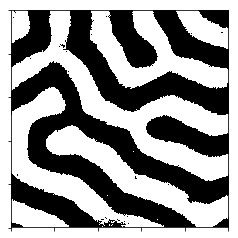

In [2]:
#正解データの読み込み
t_img  = np.array(Image.open("tri_1s.png").convert("L"))
#t_img =  (t_img - np.mean(t_img))/np.std(t_img)

#正解データの二値化
t_img = t_img > threshold_otsu(t_img).astype(np.int)
t_img =  (t_img - np.mean(t_img))/np.std(t_img)

#正解データの表示
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.imshow(t_img, cmap = 'gray')

In [3]:
#『1枚時のDifferenceを1に規格化するため，1枚時のDifferenceを求める』

#積算枚数1枚時の画像の読み込み
first_im = np.array(Image.open("tri_noise1.png").convert("L"))
#first_im =  (first_im - np.mean(first_im))/np.std(first_im)

#積算枚数1枚時の画像の二値化と標準化
first_im = first_im > threshold_otsu(first_im).astype(np.int)
first_im =  (first_im - np.mean(first_im))/np.std(first_im)

#正解画像との差分を各画素ごとに取り，絶対値表示したのち平均化
first_dif = (t_img - first_im)
first_dif = np.abs(first_dif)
first_dif = np.sum(first_dif) / np.size(first_dif)
print(first_dif)

0.6218291496128691


In [4]:
#以下マルコフ確率場および確率伝搬法を用いたノイズ除去の設定

In [5]:
class MRF:
    
    def __init__(self):
        self.nodes = [] #MRF上のノード
        self.id = {} #ノードのID

    #MRFにノードを追加する
    
    def addNode(self, id, node):
        self.nodes.append(node)
        self.id[id] = node

    #IDに応じたノードを返す
    
    def getNode(self, id):
        return self.id[id]

    #全部のノードを返す
    
    def getNodes(self):
        return self.nodes

    #確率伝播を開始する
    
    def beliefPropagation(self, iter=5):

        #各ノードについて隣接ノードからのメッセージを初期化
        for node in self.nodes:
            node.initializeMessage()

        #一定回数繰り返す
        for t in range(iter):
            print(t)

            #各ノードについて，そのノードに隣接するノードへメッセージを送信する
            for node in self.nodes:
                for neighbor in node.getNeighbor():
                    neighbor.message[node] = node.sendMessage(neighbor)

        #各ノードについて周辺分布を計算する
        for node in self.nodes:
            node.marginal()

In [6]:
class Node(object):
    
    def __init__(self, id):
        self.id = id
        self.neighbor = []
        self.message = {}
        self.prob = None

        #エネルギー関数用パラメータ
        self.alpha = a
        self.beta = b
        
    
    def addNeighbor(self, node):
        self.neighbor.append(node)
        
    
    def getNeighbor(self):
        return self.neighbor

    #隣接ノードからのメッセージを初期化
    
    def initializeMessage(self):
        for neighbor in self.neighbor:
            self.message[neighbor] = np.array([Decimal("1.0"),Decimal("1.0")])

    #全てのメッセージを統合
    #probは周辺分布
    
    def marginal(self):
        prob = Decimal("1.0")

        for message in self.message.values():
            prob *= message

        prob /= np.sum(prob)
        self.prob = prob

    #隣接ノードの状態を考慮した尤度を計算
    
    def sendMessage(self, target):
        neighbor_message = Decimal("1.0")
        
        for neighbor in self.message.keys():
            if neighbor != target:
                neighbor_message *= self.message[neighbor]

        compatibility_0 = np.array([np.exp(-self.beta * np.abs(Decimal(0.0) - Decimal(0.0))), np.exp(-self.beta * np.abs(Decimal(0.0) - Decimal('1.0')))])
        compatibility_1 = np.array([np.exp(-self.beta * np.abs(Decimal('1.0') - Decimal(0.0))), np.exp(-self.beta * np.abs(Decimal('1.0') - Decimal('1.0')))])

        message = np.array([np.sum(neighbor_message * compatibility_0), np.sum(neighbor_message * compatibility_1)])
        message /= np.sum(message)

        return message

    #観測値から計算する尤度
    
    def calcLikelihood(self, value):
        likelihood = np.array([Decimal(0.0), Decimal(0.0)])

        if value == 0:
            likelihood[0] = np.exp(-1*self.alpha * Decimal(0))
            likelihood[1] = np.exp(-1*self.alpha *  Decimal('1.0'))
        else:
            likelihood[0] = np.exp(-self.alpha * Decimal('1.0'))
            likelihood[1] = np.exp(-self.alpha * Decimal(0))

        self.message[self] = likelihood

In [7]:
#各画素ごとにノードを作成し，隣接画素ノードとの接続を作成する

def generateBeliefNetwork(image):
    network = MRF()
    height, width = image.shape

    for i in range(height):
        for j in range(width):
            nodeID = width * i + j
            node = Node(nodeID)
            network.addNode(nodeID, node)

    dy = [-1, 0, 0, 1]
    dx = [0, -1, 1, 0]

    for i in range(height):
        for j in range(width):
            node = network.getNode(width * i + j)

            for k in range(4):
                if i + dy[k] >= 0 and i + dy[k] < height and j + dx[k] >= 0 and j + dx[k] < width:
                    neighbor = network.getNode(width * (i + dy[k]) + j + dx[k])
                    node.addNeighbor(neighbor)

    return network

In [8]:
#以下マルコフ確率場および確率伝搬法を用いたノイズ除去の実行

In [9]:
x = [] #ノイズ画像の信用度を示すパラメータαの値
xx = []

y = [] #隣接画素の相互作用の強さを示すパラメータβの値
yy = []

z = [] #Difference値
zz = []

r = []

In [10]:

a=1 
b=1 
@jit
def NoiseReduction():
    #読み込み画像の配列化および標準化
    img  = np.array(Image.open("tri_noise1.png").convert("L"))
    im = img > threshold_otsu(img).astype(np.int)
    for a in itertools.count(start=Decimal('1.6'), step=Decimal('0.1')):
        r.clear()
        for b in itertools.count(start=Decimal('1.6'), step=Decimal('0.1')):

#MRF構築
            network = generateBeliefNetwork(im)

#観測値（画素値）から尤度を作成
            for i in range(im.shape[0]):
                for j in range(im.shape[1]):
                    node = network.getNode(im.shape[1] * i + j)
                    node.calcLikelihood(im[i,j])

#確率伝播法を行う
            network.beliefPropagation()

#周辺分布は[0の確率,1の確率]の順番
#もし1の確率が大きければoutputの画素値を1に変える
            output = np.zeros(im.shape)

            for i in range(output.shape[0]):
                for j in range(output.shape[1]):
                    node = network.getNode(output.shape[1] * i + j)
                    prob = node.prob
                    if prob[1] > prob[0]:
                        output[i,j] = 1

            plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
            plt.imshow(output,cmap="gray")
            plt.show()
        
            out =  (output - np.mean(output))/np.std(output)
            dif_cell = (out - t_img)
            dif_cell = np.abs(dif_cell)
            dif = np.sum(dif_cell) / np.size(dif_cell)
            dif = dif / first_dif
        
            print("α =" + str(a),"β =" + str(b))
            print("Difference")
            print(dif)
        
            xx.append(a)
            yy.append(b)
            zz.append(dif)
        
            if len(y) < b:
                y.append(b)
            r.append(dif)
        
            if b > Decimal('2.5'):
                break
        x.append(a)
        z.append(r.copy())
        if a > Decimal('2.5'):
            break
        


In [11]:
with multiprocessing.dummy.Pool(multiprocessing.cpu_count()) as p:
    p.map(NoiseReduction())

0
1
2


KeyboardInterrupt: 

In [ ]:
#α，β，Differenceを表にまとめる
print("α"+ str(x))
print("β"+ str(y))
print("Difference"+ str(z))
nr = pd.DataFrame(z,index=x,columns=y)
#nr = nr.rename(columns={1.0: 'β=1.0'}, index={1.0: 'α=1.0'})
print(nr)


In [ ]:
%matplotlib inline
plt.figure(figsize=(12, 8)) 
sns.heatmap(nr, cmap='Blues', annot=True, square=True, fmt="1.3f")

In [ ]:
#最小のDifference値
min_dif = min(zz)

#上記の値のindex
min_dif_index = zz.index(min_dif)

#上記のDifference値の時のα及びβ
x_value = xx[min_dif_index]
y_value = yy[min_dif_index]

print("Best noise reduction")
print("α= "+ str(x_value),"β= "+ str(y_value),"Difference: "+ str(min_dif))
